# Annotating Macromolecular Complexes in the Protein Data Bank: Improving the FAIRness of Structure Data

## Disclaimer

This Jupyter notebook is supplementary material for the publication:

**"Annotating Macromolecular Complexes in the Protein Data Bank: Improving the FAIRness of Structure Data"**, Sri A et al., BioRxiv

The code in this notebook reproduces the analysis presented in the publication.

## Background

Macromolecular complexes are crucial functional units in virtually all cellular processes. Their atomic-level understanding is vital to understanding molecular mechanisms and affects applications, such as developing new therapeutics. The Protein Data Bank (PDB) is the central repository for experimentally determined macromolecular structures. However, it can be challenging to find all instances that represent the same assembly in the PDB due to the current PDB annotation practices, which do not include the annotation of assemblies. This study highlights the importance of annotations for macromolecular complexes and the need for more robust methods to identify and classify these complexes across the PDB. We propose a new approach that uses external resources such as the Complex Portal and Gene Ontology to describe assemblies accurately and put them into their biological contexts. We anticipate that the new approach to identifying and classifying complexes will improve the usability and utility of the PDB for researchers in the field of structural biology and drug discovery.

### Primary use case of this Jupyter notebook

This notebook demonstrates how to extract assembly information from the data generated by the weekly-updated complex identifier process of PDBe.
Using this notebook, or by slightly editing the code presented here, it is easy to identify assemblies such as:

* Protein-only assemblies
* Assemblies containing RNA or DNA
* Assemblies with components unmapped to UniProt (e.g. antibodies)

## Importing dependencies

This code imports several modules that are used in the script.

* The `pandas` module is used for data manipulation and analysis
* `utility` is a custom module that contains utility functions used in the script
* `matplotlib` is a plotting library and `pyplot` is a sublibrary within it, often used for creating static, two-dimensional plots.
* `constants` is a custom module that contains constants used in the script. `UNIPROT_PATTERN` and `RFAM_PATTERN` are constants that are defined in the constants module and used in the script.

In [10]:
import csv
from collections import Counter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

The code block below contains some variables that store Regex patterns for identifying UniProt/Rfam accessions

In [11]:
# Regex pattern for identifying UniProt accession
UNIPROT_PATTERN = r"([A-N,R-Z][0-9]([A-Z][A-Z, 0-9][A-Z, 0-9][0-9]){1,2})|([O,P,Q][0-9][A-Z, 0-9][A-Z, 0-9][A-Z, 0-9][0-9])(\.\d+)?"
# Regex pattern for identifying Rfam accession
RFAM_PATTERN = r"RF\d{5}"

# This dict contains the definitions of the various unmapped component types
UNMAPPED_COMPONENTS = {
  "all": ("antibody", "Protein_", "RNA_", "DNA_", "DNA/RNA_"),
  "protein": "Protein_",
  "antibody": "antibody_",
  "na": ("RNA_", "DNA_", "DNA/RNA_")
}

## Utility methods

The code block below contains some utility methods used for data analysis

In [13]:
def get_prefered_assembly_str(assembly_str):
 """
 This method returns a string of prefered assemblies
 """
 prefered_assemblies = []
 assemblies = assembly_str.split(",")
 for assembly in assemblies:
    prefered_assembly = prefered_assemblies_dict.get(assembly)
    if prefered_assembly is True:
        prefered_assemblies.append(assembly)
 return ",".join(prefered_assemblies)


def check_for_protein(assembly_string):
  """
  This method checks if the unique assembly contains a protein
  component
  """  
  if re.search(UNIPROT_PATTERN, assembly_string):
    return True
  elif "Protein_" in assembly_string:
    return True
  elif "antibody_" in assembly_string:
    return True
  elif "peptide_" in assembly_string:
    return True
  else:
    return False

def check_for_rna(assembly_string):
  """
  This method checks if the unique assembly contains a RNA
  component
  """  
  if re.search(RFAM_PATTERN, assembly_string):
    return True
  elif "RNA_" in assembly_string:
    return True
  elif "mRNA_" in assembly_string:
    return True
  else:
    return False

def check_for_dna(assembly_string):
  """
  This method checks if the unique assembly contains a DNA
  component
  """  
  if "DNA_" in assembly_string:
    return True
  else:
    return False

def validate_uniprot(assembly_string, query_type):
  """
  This method checks whether any or all the components in an unique assembly 
  are mapped to UniProt
  """  
  assembly_components = assembly_string.split(",")
  uniprot_matches = [bool(re.search(UNIPROT_PATTERN, component)) for component in assembly_components]
  return query_type(uniprot_matches)

def validate_rfam(assembly_string, query_type):
  """
  This method checks whether any or all the components in an unique assembly
  are mapped to Rfam
  """  
  assembly_components = assembly_string.split(",")
  rfam_matches = [bool(re.search(RFAM_PATTERN, component)) for component in assembly_components]
  return query_type(rfam_matches)

def assembly_composition(valid_protein, valid_RNA, valid_DNA):
  """
  This method returns the assembly polymer composition string
  """
  composition = set()
  if valid_protein:
    composition.add("protein") 
  if valid_RNA:
    composition.add("RNA") 
  if valid_DNA:
    composition.add("DNA")
        
  return ",".join(list(composition))

def get_asymmetrical_assemblies(assembly, sym_operator):
  """
  This method returns a string of assemblies that are
  asymmetrical
  """  
  asymmetrical_assemblies = []
  assembly = assembly.split(",")
  sym_operator = sym_operator.split(",")
  for assembly, sym_operator in zip(assembly, sym_operator):
    if sym_operator == "no-sym":
      asymmetrical_assemblies.append(assembly)
  return ", ".join(asymmetrical_assemblies)

def get_extended_symmetry_operators(assembly, sym_operator):
  """
  This method returns a string of assemblies with their
  symmetry operators
  """   
  assemblies = []
  assembly = assembly.split(",")
  sym_operator = sym_operator.split(",")
  for assembly, sym_operator in zip(assembly, sym_operator):
    assemblies.append(f"{assembly}|{sym_operator}")
  return ", ".join(assemblies)

def most_frequent_symmetry(symmetry_list):
  """
  This method returns the most frequent symmetry operator observed
  for an unique assembly
  """  
  symmetry_list = symmetry_list.split(",")
  occurence_count = Counter(symmetry_list)
  return occurence_count.most_common(1)[0][0]

def get_unique_symmetries(symmetry_list):
  """
  This method returns all the distinct symmetry operators observed
  for an unique assembly joined together as a string
  """  
  result = set(symmetry_list.split(","))
  return ", ".join(list(result))

def get_assembly_type(assembly_string):
  """
  This method returns the assembly type - monomeric, homomeric or 
  heteromeric
  """
  assembly_components = assembly_string.split(",")
  if len(assembly_components) > 1:
    assembly_type = "heteromeric"
  else:
    *_, stoic = assembly_string.split("_")
    if stoic == str(1):
        assembly_type = "monomeric"
    else:
        assembly_type = "homomeric"
  return assembly_type    

def group_UniProt_accessions(data):
  """
  This method returns a dict where the key is an UniProt accession
  while the value is a list of stoichiometry numbers
  """  
  grouped_UNP_accessions = {}
  for elem in data:
    accession, stoichiometry = elem.split("_")
    grouped_UNP_accessions.setdefault(accession, []).append(stoichiometry)
  return grouped_UNP_accessions

def group_subassemblies(data):
  grouped_subassemblies = {}
  grouped_superassemblies = {}
  for elem in data:
    grouped_subassemblies.setdefault(elem[0], []).append(elem[1])
    grouped_superassemblies.setdefault(elem[1], []).append(elem[0])
  return grouped_subassemblies, grouped_superassemblies

def get_sym_op(data):
  """
  This method generates the symmetry operator string for all the assemblies
  of an unique assembly
  """  
  assemblies_list = data.split(",")
  sym_op_list = [SYMMETRY_MAPPING.get(assembly, "no-sym") for assembly in assemblies_list]
  return ",".join(sym_op_list)

def validate_consistent_symmetry(data):
  """
  This method returns True if all assemblies of an unique assembly has the same 
  symmetry operator
  """  
  symmetry_list = data.split(",")
  if len(set(symmetry_list)) == 1:
    return True
  else:
    return False

def count_unique_symmetry(data):
  """
  This method calculates number of unique symmetry observed for an unique
  assembly
  """  
  symmetry_list = data.split(",")
  return len(set(symmetry_list))

def count_assemblies(data):
  """
  This method calculates the number of assemblies for an unique assembly
  """  
  assemblies_list = data.split(",")
  return len(assemblies_list)

def count_unique_pdb(data):
  """
  This method calculates the number of PDB entries for an unique assembly
  """   
  assemblies_list = data.split(",")
  pdb_list = [assembly.split("_")[0] for assembly in assemblies_list]
  return len(set(pdb_list))

def get_sym_variant(ref_symmetry, assemblies):
  """
  This method returns a string of assemblies that do not have the same
  symmetry operator as the rest of assemblies for an unique assembly
  """  
  assemblies = assemblies.split(",")
  variants = []
  for assembly in assemblies:
    _, sym = assembly.split("|")
    if sym != ref_symmetry:
      variants.append(assembly)
  return ", ".join(variants)

def dict_compare(d1, d2):
  """
  This is a general method that compares two dictionaries
  """
  d1_keys = set(d1.keys())
  d2_keys = set(d2.keys())
  shared_keys = d1_keys.intersection(d2_keys)
  added = d1_keys - d2_keys
  removed = d2_keys - d1_keys
  modified = {o : (d1[o], d2[o]) for o in shared_keys if d1[o] != d2[o]}
  same = set(o for o in shared_keys if d1[o] == d2[o])
  return added, removed, modified, same

def validate_unmapped(assembly_string, component_type="all"):
  """
  This method checks whether the unique assembly contains unmapped components 
  based on the component_type
  """  
  assembly_components = assembly_string.split(",")
  unmapped_components = [component.startswith(UNMAPPED_COMPONENTS[component_type]) for component in assembly_components]
  return all(unmapped_components)

def get_species_name(assembly_components_string):
  """
  This method returns the species name for an unique assembly based on
  mapped UniProt components
  """  
  assembly_components = assembly_components_string.split(",")
  component_accession = [component.split("_")[0] for component in assembly_components]
  components_names = [UNP_TAX_NAME.get(component) for component in component_accession]
  most_frequent_name = Counter(components_names)
  return most_frequent_name.most_common(1)[0][0]

def get_exp_methods(assemblies_string):
  """
  This method returns a string of experimental-methods used to solve the structures of
  assemblies for an unique assembly
  """  
  exp_method_per_composition = set()
  assemblies = assemblies_string.split(",")
  assemblies = [assembly.split("_")[0] for assembly in assemblies]

  for assembly in assemblies:
      assembly_exp_method = EXP_METHOD.get(assembly)
      if assembly_exp_method == "hybrid":
          exp_method_per_composition.add("Hybrid")
      elif assembly_exp_method == "x-ray":
          exp_method_per_composition.add("X-ray")
      elif assembly_exp_method == "nmr":
          exp_method_per_composition.add("NMR")
      elif assembly_exp_method == "other":
          exp_method_per_composition.add("Other")
      elif assembly_exp_method == "em":
          exp_method_per_composition.add("EM")
      elif assembly_exp_method == "sas":
          exp_method_per_composition.add("SAS")
      
  combined_methods = sorted(list(exp_method_per_composition)) 
  return ",".join(combined_methods) 

def create_prefered_assemblies_string(assemblies, prefered_assemblies):
   """
   This method returns a string of prefered assemblies
   """ 
   assemblies_str_list = []
   for x,y in zip(str(assemblies).split(","), str(prefered_assemblies).split(",")):
      if y == "True":
         assemblies_str_list.append(x)
   return ",".join(assemblies_str_list) 

def check_for_chimeric_chains(assembly_components_str):
   """
   This method checks whether the unique assembly contains chimeric chains
   """ 
   if ":" in assembly_components_str:
      return True
   elif "::" in assembly_components_str:
      return True
   else:
      return False

def format_species_name(name):
    """
    This method formats the species name
    """
    name_components = name.split(" ")
    if len(name_components) == 2:
        name = name
    elif len(name_components) > 2:
        name = " ".join(name_components[:2])
    return name

The code block below contains some variables that store secondary data for analysis

In [14]:
sm = pd.read_csv('data/symmetry_reference.csv')
# Symmetry operator information for protein assemblies in PDB
SYMMETRY_MAPPING = dict(zip(sm.ID, sm.SYMMETRY))

ep = pd.read_csv('data/pdb_exp_method.csv')
# Experimental method information for PDB entries
EXP_METHOD = dict(zip(ep.ID, ep.METHOD_CLASS))

sn = pd.read_csv('data/uniprot_tax.csv')
sn['FORMATTED_NAME'] = sn["NAME"].apply(lambda x: format_species_name(x))
# Species name information for Uniprot accessions
UNP_TAX_NAME = dict(zip(sn.ACCESSION, sn.FORMATTED_NAME))

## Pre-Processing

This section contains some pre-processing that we need to do before analysing the data

In [15]:
# Read the CSV file containing the data on assemblies
df = pd.read_csv("data/assemblies_data.csv")
prefered_assemblies_dict = dict(zip(df['ASSEMBLIES'], df['PREFERED_ASSEMBLIES']))

In [16]:
# Group the rows in dataframe based on the assembly string
df = df.astype(str).groupby('ASSEMBLY_STRING', sort=False).agg(lambda x: ','.join(x.unique())).reset_index()
# Drop the existing PREFERED_ASSEMBLIES col in the dataframe
df = df.drop('PREFERED_ASSEMBLIES', axis=1)

In [17]:
# Create a new column that shows the prefered assemblies string for each unique assembly composition
df["PREFERED_ASSEMBLIES"] = df["ASSEMBLIES"].apply(lambda x: get_prefered_assembly_str(x))

In [18]:
# Create a new column that indicates whether each unique assembly composition contains chimeric chains
df["hasChimericChains"] = df["ASSEMBLY_STRING"].apply(lambda x: check_for_chimeric_chains(x))
# Exclude unique assemblies that contain chimeric chains
df = df[df["hasChimericChains"] == False]

## Assembly Classification

We can classify the assemblies into three types:
* monomeric
* homomeric
* heteromeric

A monomeric assembly is defined as an assembly that consists of a single subunit. Homomeric assemblies are formed by repeated units of a single subunit while heteromeric assemblies are composed of multiple distinct subunits. 

In [19]:
df["ASSEMBLY_TYPE"] = df["ASSEMBLY_STRING"].apply(lambda x: get_assembly_type(x))

In [20]:
# Num of monomeric assemblies
df[df["ASSEMBLY_TYPE"] == "monomeric"].shape[0]

31206

In [21]:
# Num of homomeric assemblies
df[df["ASSEMBLY_TYPE"] == "homomeric"].shape[0]

36616

In [22]:
# Num of heteromeric assemblies
df[df["ASSEMBLY_TYPE"] == "heteromeric"].shape[0]

31292

## 1) Assemblies analysis

This section contains some general analyses that were carried out on assemblies across the whole PDB archieve in order to learn their numbers, composition of the assemblies and how many components in the assemblies are mapped to external resources such as [UniProt](https://www.uniprot.org/) for protein entities and [Rfam](https://rfam.org/) for RNA entities

### 1.2) Basic statistics

#### 1.2.1) Unique assemblies

First, we check how many unique assembly compositions are there in the PDB.

In [23]:
print("There are %i unique assembly compositions in the Protein Data Bank." % len(df))

There are 99114 unique assembly compositions in the Protein Data Bank.


In [24]:
# Column to indicate the exp methods used to solved the structures of each unique assembly composition
df["EXP_METHOD"] = df["ASSEMBLIES"].apply(lambda x: get_exp_methods(x))
exp_methods = df["EXP_METHOD"].value_counts().head(20)
exp_methods

EXP_METHOD
X-ray                     73613
EM                        14573
NMR                        7789
NMR,X-ray                  1809
EM,X-ray                   1016
EM,NMR,X-ray                 75
Hybrid,X-ray                 62
Hybrid                       55
EM,NMR                       27
Hybrid,NMR,X-ray             13
Other,X-ray                  12
SAS                           9
Hybrid,Other,X-ray            9
Hybrid,NMR                    7
SAS,X-ray                     6
EM,Hybrid,X-ray               5
Other                         5
NMR,Other,X-ray               5
Hybrid,NMR,Other,X-ray        5
EM,Hybrid,NMR,X-ray           4
Name: count, dtype: int64

In [25]:
# Column to indicate the species name for each unique assembly composition
df["SPECIES_NAME"] = df["ASSEMBLY_STRING"].apply(lambda x: get_species_name(x))
df["SPECIES_NAME"].value_counts().head(10)

SPECIES_NAME
Homo sapiens                  17722
Escherichia coli               4486
Mus musculus                   3092
Saccharomyces cerevisiae       2982
Pseudomonas aeruginosa         1219
Arabidopsis thaliana           1183
Mycobacterium tuberculosis     1159
Thermus thermophilus           1051
Rattus norvegicus              1044
Bacillus subtilis               977
Name: count, dtype: int64

#### 1.2.2) Unique assemblies containing proteins

Next, we look at how many of these unique assemblies contain proteins.

In [26]:
# Column to indicate the number of assemblies each unique assembly has
df["NUM_ASSEMBLIES"] = df["ASSEMBLIES"].apply(lambda x: count_assemblies(x))

# Column to indicate the number of distinct PDBIDs each unique assembly has
df["NUM_PDB"] = df["ASSEMBLIES"].apply(lambda x: count_unique_pdb(x))

# Column to indicate whether each unique assembly has a protein component
df["hasProteinComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: check_for_protein(x))

df[df["hasProteinComponent"] == True].head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,Streptomyces viridosporus,2,2,True
1,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",853cd30c94186dfa426b6e40a8458371,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100002,nan,nan,nan,7uvx_1,7uvx_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True
2,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",3229873054b7091ab541a90556d9d414,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100003,nan,nan,nan,7uvy_1,7uvy_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True
3,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",5e271ae707119b3ec49ee47a12409d95,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100004,nan,nan,nan,7uvz_1,7uvz_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True
4,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",13c8f3476adda75af3f3ad08a818ad0e,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100005,nan,nan,nan,7uw1_1,7uw1_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True


In [27]:
print("There are %i unique assemblies containing protein components." % len(df[df["hasProteinComponent"] == True]))

There are 94578 unique assemblies containing protein components.


#### 1.2.3) Unique assemblies containing RNAs

We can also count assemblies that contain RNA molecules.

In [28]:
# Column to indicate whether each unique assembly has a RNA component
df["hasRNAComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: check_for_rna(x))

df[df["hasRNAComponent"] == True]

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent
1,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",853cd30c94186dfa426b6e40a8458371,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100002,nan,nan,nan,7uvx_1,7uvx_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
2,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",3229873054b7091ab541a90556d9d414,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100003,nan,nan,nan,7uvy_1,7uvy_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
3,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",5e271ae707119b3ec49ee47a12409d95,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100004,nan,nan,nan,7uvz_1,7uvz_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
4,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",13c8f3476adda75af3f3ad08a818ad0e,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100005,nan,nan,nan,7uw1_1,7uw1_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
5,"A0A009I821_1,A0A1V3DIZ9_1,A0A4R0F9S8_1,A0A7U4D...",9beb54465d794d308be3c4303fa3ee20,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A4R0F9...",PDB-CPX-100006,nan,nan,nan,7uvv_1,7uvv_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101552,shRNA_9mdy_1_2,be55c053c9f4b432ea812512e8b74a1d,shRNA_9mdy_1_2|1_16,PDB-CPX-201553,nan,RNA,general nucleic acid name,9mdy_1,9mdy_1,False,homomeric,X-ray,None,1,1,False,True
101553,shRNA_9od4_1_1,4cb8dd1aadf0ff6ae9412719e8f2230f,shRNA_9od4_1_1|1_23,PDB-CPX-201554,nan,RNA,general nucleic acid name,9od4_1,9od4_1,False,monomeric,NMR,None,1,1,False,True
101554,shRNA_9od5_1_1,5e978982d78adbc815a9da7fdb68cd25,shRNA_9od5_1_1|1_23,PDB-CPX-201555,nan,RNA,general nucleic acid name,9od5_1,9od5_1,False,monomeric,NMR,None,1,1,False,True
101555,shRNA_9qzj_1_1,d7d876225f4c4769332e6a6c6c2be77b,shRNA_9qzj_1_1|1_19,PDB-CPX-201556,nan,RNA,general nucleic acid name,9qzj_1,9qzj_1,False,monomeric,NMR,None,1,1,False,True


In [29]:
print("There %i unique assemblies containing RNA components." % len(df[df["hasRNAComponent"] == True]))

There 5603 unique assemblies containing RNA components.


#### 1.2.4) Unique assemblies containing DNAs

Finally, we count the assemblies which contain DNA molecules.

In [30]:
# Column to indicate whether each unique assembly has a DNA component
df["hasDNAComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: check_for_dna(x))

df[df["hasDNAComponent"] == True].head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent
67,"A0A023R6W2_60,DNA_5j37_2_60",de44e342694e89ee1020b50812ee115e,"A0A023R6W2_60|15_247,DNA_5j37_2_60|1_30",PDB-CPX-100068,nan,Putative capsid protein and DNA,protein name from UniProt and DNA,5j37_1,5j37_1,False,heteromeric,X-ray,Beak and,1,1,True,False,True
111,"A0A024L3Y3_1,A0A369F490_1,A0A5B9AW69_2,C3SIA7_...",86e3a775cb1ca3489c05891cdc94353f,"A0A024L3Y3_1|1_1148,A0A369F490_1|16_1373,A0A5B...",PDB-CPX-100112,nan,nan,nan,9n11_1,9n11_1,False,heteromeric,EM,Escherichia coli,1,1,True,False,True
112,"A0A024L3Y3_1,A0A5B9AW69_2,C3SIA7_1,DNA_9n07_6_...",7c0cc433540a5dac655bc3553c1525dc,"A0A024L3Y3_1|1_1148,A0A5B9AW69_2|4_237,C3SIA7_...",PDB-CPX-100113,nan,nan,nan,9n07_1,9n07_1,False,heteromeric,EM,Escherichia coli,1,1,True,False,True
117,"A0A024R7E8_1,A0A0B8RVL1_1,A0A4X1TRS6_1,A0A4X1V...",a86818e84c8e90ebd551a57ae8959a48,"A0A024R7E8_1|22_104,A0A0B8RVL1_1|1_1174,A0A4X1...",PDB-CPX-100118,nan,nan,nan,9hwg_1,9hwg_1,False,heteromeric,EM,Sus scrofa,1,1,True,True,True
148,"A0A037Y8L6_1,A0A0E2L017_1,A0A1X3JA73_1,A0A828U...",65af1ed353f09b2fde0d7f0b5faec8b8,"A0A037Y8L6_1|1_144,A0A0E2L017_1|1_38,A0A1X3JA7...",PDB-CPX-100149,nan,30S small ribosomal subunit and RNA and DNA,complex portal super-complex,8ury_1,8ury_1,False,heteromeric,EM,Escherichia coli,1,1,True,True,True


In [31]:
print("There %i unique assemblies containing DNA components." % len(df[df["hasDNAComponent"] == True]))

There 6378 unique assemblies containing DNA components.


### 1.2.5) Summarising what we found so far

Let's summarise how many assemblies fall into specific categories based on their compositions.

In [32]:
"""
Column to indicate the type of polymer present in each unique assembly. The polymer can either  be protein, 
DNA, or RNA
"""
df["ASSEMBLY_POLYMERS"] = df.apply(lambda row: assembly_composition(row["hasProteinComponent"], row["hasRNAComponent"], row["hasDNAComponent"]), axis=1)

In [33]:
assemblies_polymer_composition = df["ASSEMBLY_POLYMERS"].value_counts()
assemblies_polymer_composition

ASSEMBLY_POLYMERS
protein            87742
protein,RNA         3232
protein,DNA         3080
DNA                 2689
RNA                 1762
protein,RNA,DNA      524
RNA,DNA               85
Name: count, dtype: int64

Let's visualise the data using a bar chart.

Text(0.5, 1.0, 'Assemblies polymer composition in PDB')

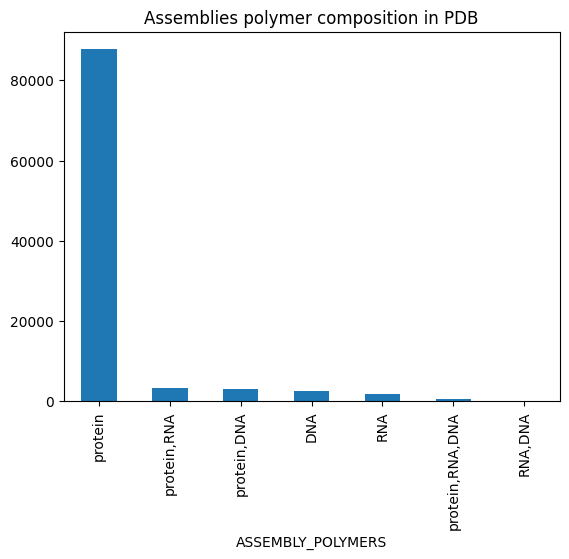

In [34]:
ax = assemblies_polymer_composition.plot(kind="bar")
ax.set_title("Assemblies polymer composition in PDB")

We can see that the vast majority of assemblies in the PDB are protein assemblies followed by DNA-protein and RNA-protein assemblies respectively.

## 1.3) Focusing on protein assemblies

Next, we will investigate some statistics of protein assemblies.

### 1.3.1) Creating protein-only assembly subset

We start by creating a data frame for protein assemblies.


### 1.3.2) Assembly components mapped to UniProt accessions

Then, we check if the components in the protein assemblies are all mapped to UniProt accessions. Reasons why a protein may not be mapped to a UniProt accession include:

* Length limitation (sequence too short to map reliably)
* Type limitation (certain classes of proteins, such as antibodies, have no UniProt accessions

In [35]:
# Create a new dataframe to represent protein assemblies
df_protein = df[df["ASSEMBLY_POLYMERS"] == "protein"].copy()
df_protein.head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,Streptomyces viridosporus,2,2,True,False,False,protein
14,A0A009IHW8_1,9a194c77dd71768ccf435eaa42f112f3,A0A009IHW8_1|134_267,PDB-CPX-100015,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,"7uwg_1,7uwg_2,7uwg_3,7uwg_4",7uwg_2,False,monomeric,X-ray,Acinetobacter baumannii,4,1,True,False,False,protein
15,A0A009IHW8_2,34ab074d8cc92ab208ff6f1753888d84,A0A009IHW8_2|134_269,PDB-CPX-100016,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,8g83_1,8g83_1,False,homomeric,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein
16,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100017,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,homomeric,EM,Acinetobacter baumannii,1,1,True,False,False,protein
17,A0A009PZ93_2,79e1453664385ee6e16aa3be932e7a69,A0A009PZ93_2|1_149,PDB-CPX-100018,nan,Lysozyme,protein name from UniProt,9kbq_1,9kbq_1,False,homomeric,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein


In [36]:
df_protein.shape[0]

87742

In [37]:
# Column to indicate whether all components in the protein assembly are mapped to UniProt
df_protein["hasAllUNPMapping"] = df_protein["ASSEMBLY_STRING"].apply(lambda x: validate_uniprot(x, all))

In [38]:
# Number of protein assemblies with all components mapped to UniProt
mapped_protein_assemblies_all = df_protein[df_protein["hasAllUNPMapping"] == True]
mapped_protein_assemblies_all.head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,Streptomyces viridosporus,2,2,True,False,False,protein,True
14,A0A009IHW8_1,9a194c77dd71768ccf435eaa42f112f3,A0A009IHW8_1|134_267,PDB-CPX-100015,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,"7uwg_1,7uwg_2,7uwg_3,7uwg_4",7uwg_2,False,monomeric,X-ray,Acinetobacter baumannii,4,1,True,False,False,protein,True
15,A0A009IHW8_2,34ab074d8cc92ab208ff6f1753888d84,A0A009IHW8_2|134_269,PDB-CPX-100016,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,8g83_1,8g83_1,False,homomeric,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein,True
16,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100017,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,homomeric,EM,Acinetobacter baumannii,1,1,True,False,False,protein,True
17,A0A009PZ93_2,79e1453664385ee6e16aa3be932e7a69,A0A009PZ93_2|1_149,PDB-CPX-100018,nan,Lysozyme,protein name from UniProt,9kbq_1,9kbq_1,False,homomeric,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein,True


#### 1.3.2.1) Every component mapped to UniProt accessions

In [39]:
mapped_protein_assemblies_all.shape[0]

75246

In [40]:
# Calculate the percentage of protein assemblies with all components mapped to UniProt
print("Across the PDB, %i%% percent of protein assemblies have all of their components mapped to UniProt" % (len(mapped_protein_assemblies_all)/len(df_protein)*100))

Across the PDB, 85% percent of protein assemblies have all of their components mapped to UniProt


1.3.2.2) Any of the components mapped to UniProt accessions

In [41]:
# Column to indicate whether any one of the components in the protein assembly is mapped to UniProt
df_protein["hasAnyUNPMapping"] = df_protein["ASSEMBLY_STRING"].apply(lambda x: validate_uniprot(x, any))

In [42]:
# Number of protein assemblies with at least one component mapped to UniProt
mapped_protein_assemblies_any = df_protein[df_protein["hasAnyUNPMapping"] == True]
mapped_protein_assemblies_any.head(10)

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,...,X-ray,Streptomyces viridosporus,2,2,True,False,False,protein,True,True
14,A0A009IHW8_1,9a194c77dd71768ccf435eaa42f112f3,A0A009IHW8_1|134_267,PDB-CPX-100015,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,"7uwg_1,7uwg_2,7uwg_3,7uwg_4",7uwg_2,False,...,X-ray,Acinetobacter baumannii,4,1,True,False,False,protein,True,True
15,A0A009IHW8_2,34ab074d8cc92ab208ff6f1753888d84,A0A009IHW8_2|134_269,PDB-CPX-100016,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,8g83_1,8g83_1,False,...,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
16,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100017,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,...,EM,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
17,A0A009PZ93_2,79e1453664385ee6e16aa3be932e7a69,A0A009PZ93_2|1_149,PDB-CPX-100018,nan,Lysozyme,protein name from UniProt,9kbq_1,9kbq_1,False,...,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
23,A0A010_2,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2|1_260,PDB-CPX-100024,nan,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b00_1,5b01_1",False,...,X-ray,Streptomyces viridosporus,7,2,True,False,False,protein,True,True
24,A0A011_2,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2|1_281,PDB-CPX-100025,nan,MoeO5,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1",False,...,X-ray,Streptomyces viridosporus,5,5,True,False,False,protein,True,True
25,A0A014M399_2,c389bc2dd3f377c1ce88c5b65b04f541,A0A014M399_2|35_203,PDB-CPX-100026,nan,DAC domain-containing protein,protein name from UniProt,"7dfx_1,7dg0_1","7dfx_1,7dg0_1",False,...,X-ray,Mesomycoplasma ovipneumoniae,2,2,True,False,False,protein,True,True
26,A0A015K8Z8_4,019e5f9d97c4feb39be6b70bb3c3b8ce,A0A015K8Z8_4|1_463,PDB-CPX-100027,nan,HD domain-containing protein,protein name from UniProt,9mr6_1,9mr6_1,False,...,X-ray,Rhizophagus irregularis,1,1,True,False,False,protein,True,True
27,A0A016UNP9_1,a100af5d0caedc664680e517423c4ce6,A0A016UNP9_1|18_67,PDB-CPX-100028,nan,ShKT domain-containing protein,protein name from UniProt,2md0_1,2md0_1,False,...,NMR,Ancylostoma ceylanicum,1,1,True,False,False,protein,True,True


In [43]:
mapped_protein_assemblies_any.shape[0]

77745

In [44]:
# Calculate the percentage of protein assemblies with at least one component mapped to UniProt
print("Across the PDB archive %i%% of the protein-only assemblies have at least one component mapped to UniProt" % (len(mapped_protein_assemblies_any)/len(df_protein)*100))

Across the PDB archive 88% of the protein-only assemblies have at least one component mapped to UniProt


## 1.4) Focusing on RNA assemblies

Next, we will investigate some statistics of RNA assemblies.

### 1.4.1) Creating RNA-only assembly subset

We start by creating a data frame for RNA assemblies.

In [45]:
# Create a new dataframe to represent protein assemblies
df_rna = df[df["ASSEMBLY_POLYMERS"] == "RNA"].copy()
df_rna

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
15910,"DNA/RNA_2h0s_1_1,RF00234_1",d3c2817fa308dd962b864042821409f3,"DNA/RNA_2h0s_1_1|1_28,RF00234_1|1_125",PDB-CPX-115911,nan,nan,nan,2h0s_1,2h0s_1,False,heteromeric,X-ray,None,1,1,False,True,False,RNA
15911,"DNA/RNA_2h0z_1_1,RF00234_1",e6ae4a5562c74ec65b310ebb1cd5a732,"DNA/RNA_2h0z_1_1|1_27,RF00234_1|1_125",PDB-CPX-115912,nan,nan,nan,2h0z_1,2h0z_1,False,heteromeric,X-ray,None,1,1,False,True,False,RNA
15912,"DNA/RNA_2z74_1_1,RF00234_1",3bc5ae6748ad12ae8f02af3cdd8962f6,"DNA/RNA_2z74_1_1|1_27,RF00234_1|1_125",PDB-CPX-115913,nan,nan,nan,2z74_1,2z74_1,False,heteromeric,X-ray,None,1,1,False,True,False,RNA
15913,"DNA/RNA_2z75_1_1,RF00234_1",59238fb4093fd76acb75df148ffca9ec,"DNA/RNA_2z75_1_1|1_27,RF00234_1|1_125",PDB-CPX-115914,nan,nan,nan,2z75_1,2z75_1,False,heteromeric,X-ray,None,1,1,False,True,False,RNA
15914,"DNA/RNA_3cqs_2_1,shRNA_3cqs_1_1,shRNA_3cqs_3_1",a0aa7bbeb2acb666def353ea8f8f124f,"DNA/RNA_3cqs_2_1|1_30,shRNA_3cqs_1_1|1_13,shRN...",PDB-CPX-115915,nan,nan,nan,3cqs_1,3cqs_1,False,heteromeric,X-ray,None,1,1,False,True,False,RNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101552,shRNA_9mdy_1_2,be55c053c9f4b432ea812512e8b74a1d,shRNA_9mdy_1_2|1_16,PDB-CPX-201553,nan,RNA,general nucleic acid name,9mdy_1,9mdy_1,False,homomeric,X-ray,None,1,1,False,True,False,RNA
101553,shRNA_9od4_1_1,4cb8dd1aadf0ff6ae9412719e8f2230f,shRNA_9od4_1_1|1_23,PDB-CPX-201554,nan,RNA,general nucleic acid name,9od4_1,9od4_1,False,monomeric,NMR,None,1,1,False,True,False,RNA
101554,shRNA_9od5_1_1,5e978982d78adbc815a9da7fdb68cd25,shRNA_9od5_1_1|1_23,PDB-CPX-201555,nan,RNA,general nucleic acid name,9od5_1,9od5_1,False,monomeric,NMR,None,1,1,False,True,False,RNA
101555,shRNA_9qzj_1_1,d7d876225f4c4769332e6a6c6c2be77b,shRNA_9qzj_1_1|1_19,PDB-CPX-201556,nan,RNA,general nucleic acid name,9qzj_1,9qzj_1,False,monomeric,NMR,None,1,1,False,True,False,RNA


### 1.3.2) Assembly components mapped to Rfam accessions
Then, we check if the components in the RNA assemblies are all mapped to Rfam accessions. Reasons why an RNA may not be mapped to a Rfam accession include:

Length limitation (sequence too short to map reliably)
Type limitation (certain types, such as mRNAs, have no Rfam accessions

In [46]:
# Column to indicate whether all components in the RNA assembly are mapped to Rfam
df_rna["hasAllRfamMapping"] = df_rna["ASSEMBLY_STRING"].apply(lambda x: validate_rfam(x, all))

In [47]:
# Number of rna assemblies with all components mapped to Rfam
mapped_rna_assemblies_all = df_rna[df_rna["hasAllRfamMapping"] == True]
mapped_rna_assemblies_all.shape[0]

132

## 2) Variation of stoichiometry in assemblies in the PDB

Structures in the PDB archive are determined to investigate a specific scientific problem. Consequently, a PDB structure does not always represent the biological complex. For example, PDB entry [1abw](https://www.ebi.ac.uk/pdbe/entry/pdb/1abw) contains a human haemoglobin trimer where two copies of the alpha subunit are linked together. This trimer represents a deviation from the biological heterotetrameric state of haemoglobin. In this section of the notebook, we analyse UniProt accessions in which the assemblies exist with different stoichiometries.

In [48]:
# Create a dataframe to represent monomeric protein assemblies
df_protein_monomeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "monomeric"]
# Create a dataframe to represent homomeric protein assemblies
df_protein_homomeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "homomeric"]
# Create a dataframe to represent heteromeric protein assemblies
df_protein_heteromeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "heteromeric"]

# Calculate the percentage of monomeric protein assemblies
percentage_monomeric_assemblies = (len(df_protein_monomeric)/len(df_protein))*100
# Calculate the percentage of homomeric protein assemblies
percentage_homomeric_assemblies = (len(df_protein_homomeric)/len(df_protein))*100
# Calculate the percentage of heteromeric protein assemblies
percentage_heteromeric_assemblies = (len(df_protein_heteromeric)/len(df_protein))*100

In [49]:
print("Out of all the protein assemblies in the PDB, %i%% are monomeric, %i%% are homomeric and %i%% are heteromeric." % (
    percentage_monomeric_assemblies,
    percentage_homomeric_assemblies,
    percentage_heteromeric_assemblies
))

Out of all the protein assemblies in the PDB, 34% are monomeric, 39% are homomeric and 26% are heteromeric.


### 2.1) Homomeric protein assemblies

Next, we will investigate the homomeric protein assemblies.

In [50]:
# Create a dataframe to represent homomeric protein assemblies with all components mapped to UniProt
df_protein_homomeric_mapped = df_protein_homomeric[(df_protein_homomeric["hasAllUNPMapping"] == True)]
df_protein_homomeric_mapped

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,...,X-ray,Streptomyces viridosporus,2,2,True,False,False,protein,True,True
15,A0A009IHW8_2,34ab074d8cc92ab208ff6f1753888d84,A0A009IHW8_2|134_269,PDB-CPX-100016,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,8g83_1,8g83_1,False,...,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
16,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100017,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,...,EM,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
17,A0A009PZ93_2,79e1453664385ee6e16aa3be932e7a69,A0A009PZ93_2|1_149,PDB-CPX-100018,nan,Lysozyme,protein name from UniProt,9kbq_1,9kbq_1,False,...,X-ray,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
23,A0A010_2,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2|1_260,PDB-CPX-100024,nan,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b00_1,5b01_1",False,...,X-ray,Streptomyces viridosporus,7,2,True,False,False,protein,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94861,X5JZS1_2,29fc21acd1d8a95967c0a1d65edbd9b1,X5JZS1_2|1_222,PDB-CPX-194862,nan,Response regulator transcription factor,protein name from UniProt,5dcl_1,5dcl_1,False,...,X-ray,Streptococcus agalactiae,1,1,True,False,False,protein,True,True
94862,X5K3J9_2,ba2749960f8ee9afff9cace4e0693815,X5K3J9_2|1_223,PDB-CPX-194863,nan,HTH gntR-type domain-containing protein,protein name from UniProt,6az6_1,6az6_1,False,...,X-ray,Streptococcus agalactiae,1,1,True,False,False,protein,True,True
94864,X5KVH4_3,9e052c9a63210cf688fcbc9a59955013,X5KVH4_3|1_208,PDB-CPX-194865,nan,Chloramphenicol acetyltransferase,protein name from UniProt,6mfk_2,,False,...,X-ray,Elizabethkingia anophelis,1,1,True,False,False,protein,True,True
94865,X5MEI1_8,ac23653f4d0ae5b66ba7cad8159adfa5,"X5MEI1_8|1_206,shRNA_7mpl_2_8|1_2,X5MEI1_8|1_2...",PDB-CPX-194866,nan,3'-5' exonuclease,protein name from UniProt,"7mpl_1,7mpm_1,7mpn_1,7mpo_1,7mpp_1,7mpq_1,7mqb...","7mpl_1,7mpm_1,7mpn_1,7mpo_1,7mpp_1,7mpq_1,7mqb...",False,...,"EM,X-ray",Bartonella henselae,14,14,True,False,False,protein,True,True


Show the top 10 species of the homomeric assemblies

In [51]:
homomeric_species_count = df_protein_homomeric_mapped["SPECIES_NAME"].value_counts().head(10)
homomeric_species_count

SPECIES_NAME
Homo sapiens                  4020
Escherichia coli              1626
Mus musculus                   772
Pseudomonas aeruginosa         620
Mycobacterium tuberculosis     614
Saccharomyces cerevisiae       551
Bacillus subtilis              494
Thermus thermophilus           487
Staphylococcus aureus          451
Arabidopsis thaliana           437
Name: count, dtype: int64

Text(0.5, 1.0, 'Top 10 species from which homomeric assemblies are solved')

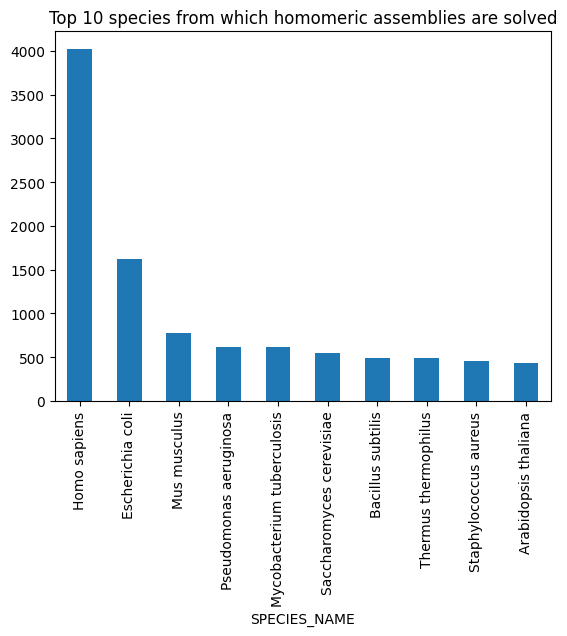

In [52]:
hx = homomeric_species_count.plot(kind="bar")
hx.set_title("Top 10 species from which homomeric assemblies are solved")

In [53]:
# Calculate the percentage of homomeric protein assemblies that have all components mapped to UniProt
percentage_homomeric_assemblies_mapped = (len(df_protein_homomeric_mapped)/len(df_protein_homomeric))*100

In [54]:
print("%i%% of the homomeric protein assemblies have all their components mapped to UniProt accession." % percentage_homomeric_assemblies_mapped)

89% of the homomeric protein assemblies have all their components mapped to UniProt accession.


We then create a list of assembly composition strings, and group them by UniProt accessions.

In [55]:
# Create a list of UniProt accessions with stoichiometry in the homomeric assemblies
homomeric_assembly_strings = df_protein_homomeric_mapped["ASSEMBLY_STRING"].tolist()

In [56]:
# Group the UniProt accessions in homomeric assemblies
homomeric_grouped_UNP_accessions = group_UniProt_accessions(homomeric_assembly_strings)
print ("There are %i groups." % len(homomeric_grouped_UNP_accessions))

There are 26696 groups.


Next, we keep only those groups that has more than one assembly states.

In [57]:
# Only keep UniProt accessions that display 2 or more stoichiometries
homomeric_UNP_accessions_with_muliple_stoic = {k: sorted([int(x) for x in grp]) for k, grp in homomeric_grouped_UNP_accessions.items() if len(grp) > 1}
# Number of UniProt accessions with multiple stoichiometry numbers
homomeric_UNP_accession_stoic_count = len(homomeric_UNP_accessions_with_muliple_stoic)

In [58]:
print("There are %i UniProt accessions that exist in different stoichiometries in homomeric assemblies" % homomeric_UNP_accession_stoic_count)

There are 3497 UniProt accessions that exist in different stoichiometries in homomeric assemblies


In [59]:
# Count the stoichiometry number for UniProt accessions with two or more stoichiometries
homomeric_UNP_accessions_with_multiple_stoic_count = [(k, len(grp)) for k, grp in homomeric_UNP_accessions_with_muliple_stoic.items()]

In [60]:
# Sort the count of stoichiometry number in descending order
sorted_homomeric_UNP_accessions_with_multiple_stoic_count = sorted(homomeric_UNP_accessions_with_multiple_stoic_count, key=lambda x: x[1], reverse=True)

In [61]:
# Show the top 10 UniProt accessions with highest stoichiometry number count
sorted_homomeric_UNP_accessions_with_multiple_stoic_count[:12]

[('P10636', 18),
 ('P05067', 17),
 ('P37840', 13),
 ('P10997', 12),
 ('P68135', 12),
 ('P02766', 10),
 ('P12493', 10),
 ('B2J6D9', 9),
 ('P03615', 9),
 ('P09651', 9),
 ('P03354', 8),
 ('Q13148', 8)]

### 2.2) Heteromeric protein assemblies

Now, we will investigate the heteromeric protein assemblies.

In [62]:
# Create a dataframe to represent heteromeric protein assemblies with all components mapped to UniProt
df_protein_heteromeric_mapped = df_protein_heteromeric[(df_protein_heteromeric["hasAllUNPMapping"] == True)]
df_protein_heteromeric_mapped.head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping
32,"A0A022MRT4_1,A0A022MRT4_1",f4c44eb7a88d77df2d16592a433f4da4,"A0A022MRT4_1|1_436,A0A022MRT4_1|1_436",PDB-CPX-100033,nan,AMP-dependent synthetase/ligase domain-contain...,protein name from UniProt,"6siw_1,6tm4_1","6siw_1,6tm4_1",False,...,X-ray,Streptomyces sp.,2,2,True,False,False,protein,True,True
36,"A0A023FDY8_1,P13500_1",b181cacca3c24b39d0b36f18bf2df31a,"A0A023FDY8_1|30_114,P13500_1|24_99",PDB-CPX-100037,nan,C-C motif chemokine 2 and Evasin P974,heterodimer,7so0_1,7so0_1,False,...,X-ray,Amblyomma cajennense,1,1,True,False,False,protein,True,True
38,"A0A023FDY8_1,P80098_1",6fecbfd42b482420704db030e5d1342f,"A0A023FDY8_1|30_114,P80098_1|24_99",PDB-CPX-100039,nan,Evasin P974 and C-C motif chemokine 7,heterodimer,"7s58_1,7s58_2,7s58_3,7s58_4",7s58_1,False,...,X-ray,Amblyomma cajennense,4,1,True,False,False,protein,True,True
39,"A0A023FDY8_1,Q92583_1",7fe71deb6c055484a5bddd7c8876e922,"A0A023FDY8_1|30_114,Q92583_1|24_94",PDB-CPX-100040,nan,Evasin P974 and C-C motif chemokine 17,heterodimer,"7s4n_1,7s4n_2",7s4n_1,False,...,X-ray,Amblyomma cajennense,2,1,True,False,False,protein,True,True
40,"A0A023FFD0_2,O15467_2",4755b24a0f433ff99903832ca171850f,"A0A023FFD0_2|29_136,O15467_2|23_120",PDB-CPX-100041,nan,C-C motif chemokine 16 and Evasin P991,heterodimer,8fk9_1,8fk9_1,False,...,X-ray,Amblyomma cajennense,1,1,True,False,False,protein,True,True


In [63]:
# Calculate the percentage of heteromeric protein assemblies that have all components mapped to UniProt
percentage_heteromeric_assemblies_mapped = (len(df_protein_heteromeric_mapped)/len(df_protein_heteromeric))*100

In [64]:
print("%i%% of the heteromeric protein assemblies have all their components mapped to UniProt accession." % percentage_heteromeric_assemblies_mapped)

78% of the heteromeric protein assemblies have all their components mapped to UniProt accession.


In [65]:
# Create a list of UniProt accessions with stoichiometry in the heteromeric assemblies
heteromeric_assembly_strings = df_protein_heteromeric_mapped["ASSEMBLY_STRING"].tolist()
heteromeric_assembly_components = [assembly.split(",") for assembly in heteromeric_assembly_strings]
heteromeric_assembly_components = [item for sublist in heteromeric_assembly_components for item in sublist] 
heteromeric_assembly_components = list(set(heteromeric_assembly_components))

In [66]:
# Group the UniProt accessions in the heteromeric assemblies
heteromeric_grouped_UNP_accessions = group_UniProt_accessions(heteromeric_assembly_components)
print ("There are %i groups." % len(heteromeric_grouped_UNP_accessions))

There are 21690 groups.


Next, we keep only those groups with more than one assembly states.

In [67]:
# Only keep UniProt accessions that display 2 or more stoichiometry number
heteromeric_UNP_accessions_with_muliple_stoic = {k: sorted([int(x) for x in grp]) for k, grp in heteromeric_grouped_UNP_accessions.items() if len(grp) > 1}
# Number of UniProt accessions with multiple stoichiometry numbers
heteromeric_UNP_accession_stoic_count = len(heteromeric_UNP_accessions_with_muliple_stoic)

In [68]:
print("There are %i UniProt accessions that exist in different stoichiometries in heteromeric assemblies" % heteromeric_UNP_accession_stoic_count)

There are 4836 UniProt accessions that exist in different stoichiometries in heteromeric assemblies


In [69]:
# Count the stoichiometry number for UniProt accessions with two or more stoichiometries
heteromeric_UNP_accessions_with_multiple_stoic_count = [(k, len(grp)) for k, grp in heteromeric_UNP_accessions_with_muliple_stoic.items()]

In [70]:
# Sort the count of stoichiometry number in descending order
sorted_heteromeric_UNP_accessions_with_multiple_stoic_count = sorted(heteromeric_UNP_accessions_with_multiple_stoic_count, key=lambda x: x[1], reverse=True)

In [71]:
# Show the top 10 UniProt accessions with highest stoichiometry number count
sorted_heteromeric_UNP_accessions_with_multiple_stoic_count[:12]

[('P68135', 16),
 ('P02554', 15),
 ('Q2XVP4', 13),
 ('Q96CW5', 9),
 ('P15928', 8),
 ('P0CG48', 8),
 ('P60709', 8),
 ('P61769', 8),
 ('P54274', 8),
 ('P98155', 7),
 ('P84077', 7),
 ('P45689', 7)]

We now compare the UniProt accessions that are used by homomeric and heteromeric assemblies

In [72]:
added, removed, modified, same = dict_compare(homomeric_UNP_accessions_with_muliple_stoic, heteromeric_UNP_accessions_with_muliple_stoic)

In [73]:
print("There are %i UniProt accessions unique for homomeric assemblies" % len(added))

There are 3061 UniProt accessions unique for homomeric assemblies


In [74]:
print("There are %i UniProt accessions unique for heteromeric assemblies" % len(removed))

There are 4400 UniProt accessions unique for heteromeric assemblies


In [75]:
print("There are %i UniProt accessions that are common to both homomeric and heteromeric assemblies with the same assembly states" % len(same))

There are 15 UniProt accessions that are common to both homomeric and heteromeric assemblies with the same assembly states


In [76]:
print("There are %i UniProt accessions that are common to both homomeric and heteromeric assemblies with varying assembly states" % len(modified))

There are 421 UniProt accessions that are common to both homomeric and heteromeric assemblies with varying assembly states


## 3) Sub-assembly analysis

A biological assembly can consist of multiple components where each component can have varying stoichiometry. This is best illustrated by the ribosome which is the molecular machine responsible for protein synthesis in every living cell. The ribosome is made up of two ribosomal subunits (small and large ribosomal subunits) and can bind multiple tRNAs (1-3 tRNAs), mRNA, and diverse protein factors. The binding of tRNAs and the various protein factors can induce the ribosome to undergo large-scale conformational changes which affects how the ribosome functions. As such, the ability to identify the sub- and super-assemblies of a biological assembly is key in identifying the contribution of each component to the function of the whole assembly and the relationships that exist between the components.

We define sub- and super-assembly using the composition and stoichiometry data. We defined a sub-assembly as an assembly where all components map to UniProt accessions and where these components are also present in another assembly. For example, PDB entry [5jdo](https://pdbe.org/5jdo) contains haemoglobin (UniProt [P68871](https://pdbe-kb.org/proteins/P68871) and UniProt [P69905](https://pdbe-kb.org/proteins/P69905)) bound to the haptoglobin-haemoglobin receptor (UniProt [G0UVW6](https://pdbe-kb.org/proteins/G0UVW6)). A sub-assembly of this assembly is haemoglobin. We defined a super-assembly as an assembly that has all the same elements of another assembly plus additional members. Again, all members must map to a UniProt accession. In the example above,  PDB entry [5jdo](https://pdbe.org/5jdo is a super-assembly of haemoglobin.

### 3.1) Reading in the data

In [77]:
df_subassemblies = pd.read_csv("data/subassemblies_data.csv")
df_subassemblies.head()

,SUBASSEMBLY_ID,SUPERASSEMBLY_ID
0,PDB-CPX-100067,PDB-CPX-100068
1,PDB-CPX-100075,PDB-CPX-100074
2,PDB-CPX-100082,PDB-CPX-100086
3,PDB-CPX-100087,PDB-CPX-100088
4,PDB-CPX-100103,PDB-CPX-100101


In [78]:
print("There are %i unique sub-assemblies, and %i unique super-assemblies in the PDB." % (
    df_subassemblies["SUBASSEMBLY_ID"].nunique(),
    df_subassemblies["SUPERASSEMBLY_ID"].nunique()
))

There are 9495 unique sub-assemblies, and 16984 unique super-assemblies in the PDB.


### 3.2) Matching sub- and super-assemblies

We can match sub- and super-assemblies.

In [79]:
subassembly_list = df_subassemblies["SUBASSEMBLY_ID"].tolist()
superassembly_list = df_subassemblies["SUPERASSEMBLY_ID"].tolist()
subassembly_pairs = list(zip(subassembly_list, superassembly_list))

In [80]:
subassembly_pairs[:10]

[('PDB-CPX-100067', 'PDB-CPX-100068'),
 ('PDB-CPX-100075', 'PDB-CPX-100074'),
 ('PDB-CPX-100082', 'PDB-CPX-100086'),
 ('PDB-CPX-100087', 'PDB-CPX-100088'),
 ('PDB-CPX-100103', 'PDB-CPX-100101'),
 ('PDB-CPX-100105', 'PDB-CPX-100104'),
 ('PDB-CPX-100106', 'PDB-CPX-100104'),
 ('PDB-CPX-100106', 'PDB-CPX-100105'),
 ('PDB-CPX-100177', 'PDB-CPX-100178'),
 ('PDB-CPX-100190', 'PDB-CPX-100191')]

In [81]:
grouped_subassemblies, grouped_superassemblies = group_subassemblies(subassembly_pairs)

In [82]:
# Assemblies having at least two super-assemblies
assemblies_with_muliple_superassembly = {k: grp for k, grp in grouped_subassemblies.items() if len(grp) > 1}
print("Only %i assemblies have 2 or more super-assemblies" % len(assemblies_with_muliple_superassembly))

Only 4438 assemblies have 2 or more super-assemblies


In [83]:
# Assemblies having at least two super-assemblies
assemblies_with_muliple_subassembly = {k: grp for k, grp in grouped_superassemblies.items() if len(grp) > 1}
print("Only %i assemblies have 2 or more sub-assemblies" % len(assemblies_with_muliple_subassembly))

Only 8757 assemblies have 2 or more sub-assemblies


### 3.3) Finding the assemblies in the PDB which have the highest number of super-assemblies

In [84]:
# Count the number of superassemblies
superassemblies_count = [(k, len(grp)) for k, grp in assemblies_with_muliple_superassembly.items()]

# Sort the count of superassemblies in descending order
sorted_superassemblies_count = sorted(superassemblies_count, key=lambda x: x[1], reverse=True)

# Show the top 10 entries with the highest number of superassemblies
sorted_superassemblies_count[:10]

# Get the PDB Complex ID for the top 10 entries
top_ten_entries_ids = [x[0] for x in sorted_superassemblies_count[:10]]

top_ten_entries_ids

# Show the assemblies data for the top 10 entries
df[df["PDB_COMPLEX_ID"].isin(top_ten_entries_ids)]

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
38162,"P0A7M6_1,P60624_1,P61175_1,RF02541_1",cadaa8f5f007b49c515c8c8e852dc990,"P0A7M6_1|1_63,P60624_1|2_103,P61175_1|1_110,RF...",PDB-CPX-138163,nan,Large ribosomal protein,common name from entity names,8c9c_1,8c9c_1,False,heteromeric,EM,Escherichia coli,1,1,True,True,False,"protein,RNA"
38999,P0ADZ0_1,2668985f3f29d7c83b11a47000742e21,P0ADZ0_1|1_93,PDB-CPX-139000,nan,Large ribosomal subunit protein uL23,protein name from UniProt,6fu8_1,6fu8_1,False,monomeric,EM,Escherichia coli,1,1,True,False,False,protein
53953,P61769_1,0712dcf6f326a1d6c8b13ed562103a4e,"P61769_1|21_119,P61769_1|27_119,P61769_1|21_11...",PDB-CPX-153954,nan,Beta-2-microglobulin,protein name from UniProt,"1jnj_1,1lds_1,1py4_1,1py4_2,1py4_3,1py4_4,2d4d...","1jnj_1,1lds_1,1py4_1,2d4d_1,2d4f_1,2vb5_1,2xks...",False,monomeric,"NMR,X-ray",Homo sapiens,64,45,True,False,False,protein
55310,P68919_1,e3ea36168fa01abbc61fcbbc72dd2734,"P68919_1|1_94,P68919_1|1_94,shRNA_1dfu_1_1|1_1...",PDB-CPX-155311,nan,Large ribosomal subunit protein bL25,protein name from UniProt,"1b75_1,1dfu_1","1b75_1,1dfu_1",False,monomeric,"NMR,X-ray",Escherichia coli,2,2,True,False,False,protein
93535,RF00001_1,3e9fac63e5859de8581783666a91255f,RF00001_1|3_118,PDB-CPX-193536,nan,5S ribosomal RNA,RNA name from Rfam,1c2x_1,1c2x_1,False,monomeric,EM,None,1,1,False,True,False,RNA
93536,"RF00001_1,RF02541_1",6be50c8e05704a0954f78d332ed58465,"RF00001_1|2_118,RF02541_1|1_2878",PDB-CPX-193537,nan,nan,nan,"3fwo_1,3jq4_1","3fwo_1,3jq4_1",False,heteromeric,X-ray,None,2,2,False,True,False,RNA
93582,RF00177_1,378262ac8af8f828e6763325b02ff009,RF00177_1|1_1533,PDB-CPX-193583,nan,Bacterial small subunit ribosomal RNA,RNA name from Rfam,"3j28_1,3j29_1,3j2a_1,3j2b_1,3j2d_1,3j2e_1,3j2f...","3j28_1,3j29_1,3j2a_1,3j2b_1,3j2d_1,3j2e_1,3j2f...",False,monomeric,EM,None,9,9,False,True,False,RNA
93584,"RF00177_1,RF02541_1",e3e6b1c911e4236c3ef1df886d1e8a24,"RF00177_1|1_1542,RF02541_1|1_2904",PDB-CPX-193585,nan,nan,nan,"3dg0_1,3dg2_1,3dg4_1,3dg5_1","3dg0_1,3dg2_1,3dg4_1,3dg5_1",False,heteromeric,EM,None,4,4,False,True,False,RNA
93667,RF02541_1,3c8c29604023f18dca86dba9b1845ad6,"RF02541_1|1_2904,RF02541_1|1_2878,RF02541_1|1_...",PDB-CPX-193668,nan,Bacterial large subunit ribosomal RNA,RNA name from Rfam,"1c2w_1,1njn_1,1njo_1,1p9x_1,1z58_1,2o43_1,2o44...","1c2w_1,1njn_1,1njo_1,1p9x_1,1z58_1,2o43_1,2o44...",False,monomeric,"EM,X-ray",None,12,9,False,True,False,RNA
93668,RF02543_1,91d3215adf6f4e1b91a264d8e7ee9c44,RF02543_1|3_3774,PDB-CPX-193669,nan,Eukaryotic large subunit ribosomal RNA,RNA name from Rfam,7zfw_1,7zfw_1,False,monomeric,EM,None,1,1,False,True,False,RNA


# 4) Naming of Assemblies

Providing a good name for a complex in the PDB poses a significant challenge. Complexes with a singular component can get the name of this component, regardless of the stoichiometry of the component. Examples of this would be Lysozyme, Insulin or Ferritin. In assemblies where the singular component is either DNA or RNA, and no mapping to external resources is present, the name is given as DNA or RNA, respectively. In the case of proteins, we can use the protein name the depositor provided if no external mapping is available. If the component maps to a UniProt accession, then we can use the protein name from UniProt. This approach allows us to automatically name some of the multi-component assemblies, including proteins bound to nucleic acids.


In [85]:
# Num of assemblies that are complexes
pdb_complexes = df[df["ASSEMBLY_TYPE"] != "monomeric"]
pdb_complexes

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,Streptomyces viridosporus,2,2,True,False,False,protein
1,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",853cd30c94186dfa426b6e40a8458371,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100002,nan,nan,nan,7uvx_1,7uvx_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
2,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",3229873054b7091ab541a90556d9d414,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100003,nan,nan,nan,7uvy_1,7uvy_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
3,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",5e271ae707119b3ec49ee47a12409d95,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100004,nan,nan,nan,7uvz_1,7uvz_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
4,"A0A009I821_1,A0A1V3DIZ9_1,A0A372MP10_1,A0A4R0F...",13c8f3476adda75af3f3ad08a818ad0e,"A0A009I821_1|1_109,A0A1V3DIZ9_1|1_101,A0A372MP...",PDB-CPX-100005,nan,nan,nan,7uw1_1,7uw1_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101549,shRNA_9kad_1_2,44db605f17e5ab263d8c204d2d3e57bd,shRNA_9kad_1_2|1_14,PDB-CPX-201550,nan,RNA,general nucleic acid name,9kad_1,9kad_1,False,homomeric,NMR,None,1,1,False,True,False,RNA
101550,shRNA_9mdw_1_2,1a367fce315db630837b9de55af17229,shRNA_9mdw_1_2|1_16,PDB-CPX-201551,nan,RNA,general nucleic acid name,9mdw_1,9mdw_1,False,homomeric,X-ray,None,1,1,False,True,False,RNA
101551,shRNA_9mdx_1_2,03e2817adce02ea8991bf726dfa60047,shRNA_9mdx_1_2|1_16,PDB-CPX-201552,nan,RNA,general nucleic acid name,9mdx_1,9mdx_1,False,homomeric,X-ray,None,1,1,False,True,False,RNA
101552,shRNA_9mdy_1_2,be55c053c9f4b432ea812512e8b74a1d,shRNA_9mdy_1_2|1_16,PDB-CPX-201553,nan,RNA,general nucleic acid name,9mdy_1,9mdy_1,False,homomeric,X-ray,None,1,1,False,True,False,RNA


## 4.1) Count the number of assemblies that have a name


In [86]:
sum_named_assemblies = (df['ASSEMBLY_NAME'] != 'nan').sum()
percentage_named_assemblies = sum_named_assemblies/df.shape[0]*100

In [87]:
print("Sum of assemblies with name: {}".format(sum_named_assemblies))

Sum of assemblies with name: 91097


In [88]:
print("Percentage of assemblies with name: {:.1f}%".format(percentage_named_assemblies))

Percentage of assemblies with name: 91.9%


## 4.2) Count the number of names generated from each naming category

In [89]:
df["NAME_SOURCE"].value_counts()

NAME_SOURCE
protein name from UniProt                   59995
heterodimer                                  9995
nan                                          8017
all_unmapped_proteins_without_antibodies     7779
general nucleic acid name                    4272
all_antibodies                               1887
complex portal                               1301
common name from entity names                1278
complex portal super-complex                  968
protein name from UniProt and DNA             939
protein name from UniProt and RNA             712
complex portal and protein                    698
Gene Ontology                                 533
complex portal and DNA                        229
ribosome (Rfam)                               198
PDBe curated                                  131
RNA name from Rfam                            118
multi complex portal complex                   19
RNA name from Rfam with unmapped RNA           19
complex portal and RNA                

We can see that majority of the names are derived from UniProt

## 4.3) Count the total number of names derived from UniProt

### 4.31) Breakdown the number of names derived from each UniProt category

In [90]:
up = df[df["NAME_SOURCE"].str.contains("UniProt", na=False)]
print(up.groupby("NAME_SOURCE").size().sort_values(ascending=False))

NAME_SOURCE
protein name from UniProt                59995
protein name from UniProt and DNA          939
protein name from UniProt and RNA          712
protein name from UniProt and peptide        1
dtype: int64


In [91]:
# Num of unique assemblies 
up.shape[0]

61647

### 4.32) Count the number of PDB entries that have names derived from UniProt

In [92]:
df.loc[df["NAME_SOURCE"].str.contains("UniProt", na=False), 'NUM_PDB'].sum()

np.int64(190609)

## 4.4) Count the total number of names derived from Complex Portal

In [93]:
# Num of unique assemblies 
df["NAME_SOURCE"].str.contains("complex portal").sum()

np.int64(3233)

### 4.41) Breakdown the number of names derived from each Complex Portal category

In [94]:
assemblies_with_ComplexPortal_names = df[df["NAME_SOURCE"].str.contains("complex portal", na=False)]
print(assemblies_with_ComplexPortal_names.groupby("NAME_SOURCE").size().sort_values(ascending=False))

NAME_SOURCE
complex portal                  1301
complex portal super-complex     968
complex portal and protein       698
complex portal and DNA           229
multi complex portal complex      19
complex portal and RNA            18
dtype: int64


### 4.42) Count the number of PDB entries that have names derived from Complex Portal

In [95]:
df.loc[df["NAME_SOURCE"].str.contains("complex portal", na=False), 'NUM_PDB'].sum()

np.int64(11707)

## 4.5) Count the number of unique assemblies & PDB entries that are named as heterodimer

In [96]:
condition = df["NAME_SOURCE"] == "heterodimer"
hd = df[condition]
# Num of unique assemblies
hd.shape[0]

9995

In [97]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(17537)

## 4.6) Count the number of unique assemblies & PDB entries that are named as ribosomes

In [98]:
condition = df["NAME_SOURCE"].str.contains("ribosome")
ribosome = df[condition]
# Num of unique assemblies
ribosome.shape[0]

205

In [99]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(226)

## 4.7) Count the number of unique assemblies & PDB entries that have names derived from Gene Ontology

In [100]:
condition = df["NAME_SOURCE"] == "Gene Ontology"
go = df[condition]
# Num of unique assemblies
go.shape[0]

533

In [101]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(1130)

In [102]:
go["ASSEMBLY_NAME"].value_counts()

ASSEMBLY_NAME
Nucleosome, Histone and DNA                                                 209
Photosystem I                                                                64
Hemoglobin complex                                                           53
Proteasome complex                                                           53
Photosystem II                                                               49
Nucleosome, Histone                                                          33
Proteasome core complex                                                      22
Myosin complex                                                               17
20S proteasome complex and Proteasome complex                                14
Nucleosome, variant H3.1-H2A.2-H2B.1 and Nucleosome, Histone and DNA          9
Respiratory chain complex IV                                                  6
Nucleosome, variant H3.2-H4-H2A.1-H2B1.1 and Nucleosome, Histone and DNA      4
Name: count, dtype: int64

## 4.8) Count the number of unique assemblies & PDB entries that have manually curated names

In [103]:
condition = df["NAME_SOURCE"] == "PDBe curated"
mc = df[condition]
# Num of unique assemblies
mc.shape[0]

131

In [104]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(567)

## 4.9) Count the number of unique assemblies & PDB entries that have general nucleic acid names

In [105]:
condition = df["NAME_SOURCE"] == "general nucleic acid name"
gn = df[condition]
# Num of unique assemblies
gn.shape[0]

4272

In [106]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(4272)

## 4.10) Count the number of unique assemblies & PDB entries that have common entity names

In [107]:
condition = df["NAME_SOURCE"] == "common name from entity names"
en = df[condition]
# Num of unique assemblies
en.shape[0]

1278

In [108]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(3339)

## 4.11) Count the number of unique assemblies & PDB entries that have all antibodies names

In [109]:
condition = df["NAME_SOURCE"] == "all_antibodies"
ab = df[condition]
# Num of unique assemblies
ab.shape[0]

1887

In [110]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(1887)

## 4.12) Count the number of unique assemblies & PDB entries that have all unmapped protein names

In [111]:
condition = df["NAME_SOURCE"] == "all_unmapped_proteins_without_antibodies"
aup = df[condition]
# Num of unique assemblies
aup.shape[0]

7779

In [112]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(7779)

## 4.13) Count the number of PDB entries that have Rfam names

In [113]:
condition = df["NAME_SOURCE"].str.contains("RNA name from Rfam")
rf = df[condition]
# Num of unique assemblies
rf.shape[0]

137

In [114]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

np.int64(561)

# 5) Symmetry analysis

PDB assemblies represent different forms that certain complex molecules, like proteins, can take. For example, a protein called haemoglobin is known to exist in two different states, one called the relaxed state, or R state, and the other called the tense state, or T state. These two states are structurally distinct from each other, meaning they have different shapes and forms. In order to gain a better understanding of these different shapes and forms, we used a computer program called [AnAnaS](https://team.inria.fr/nano-d/software/ananas/), which stands for "Analyse and Annotate Structures". This program is used to study the symmetry of different PDB assemblies, which can provide insights into the conformational heterogeneity of these complex molecules.

## 5.1) Load symmetry data

First we add several columns to the protein assembly data set:

* Symmetry operators
* A flag for consistent symmetry across various instances of the same assembly
* The number of distinct symmetry operator each unique assembly composition has

In [115]:
# Add a column to indicate the symmetry operators of the assemblies for each unique assembly composition
df_protein["SYMMETRY_OPS"] = df_protein["PREFERED_ASSEMBLIES"].apply(lambda x: get_sym_op(x))

# Add a column to indicate whether all assemblies for each unique assembly composition have consistent symmetry
df_protein["CONSISTENT_SYMMETRY"] = df_protein["SYMMETRY_OPS"].apply(lambda x: validate_consistent_symmetry(x))

# Add a column to indicate the number of distinct symmetry operators each unique assembly composition has
df_protein["SYM_NUM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: count_unique_symmetry(x))

# Add a column to show all the unique symmetries for each unique assembly composition
df_protein["ALL_SYM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: get_unique_symmetries(x))

# Add a column to show the most frequent symmetry for each unique assembly composition
df_protein["PRIMARY_SYM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: most_frequent_symmetry(x))

## 5.2) Symmetry statistics

In [116]:
df_crystal = df['EXP_METHOD'] == 'X-ray'
df_consistent = df_protein[(df_protein['CONSISTENT_SYMMETRY'] == True) & (df_protein['PRIMARY_SYM'] != "no-sym") & df_crystal]

/var/folders/qn/p72f2jb124x0vh2scsqtln940000gp/T/ipykernel_37899/3671245232.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_consistent = df_protein[(df_protein['CONSISTENT_SYMMETRY'] == True) & (df_protein['PRIMARY_SYM'] != "no-sym") & df_crystal]


In [117]:
print(f"There are {df_consistent.shape[0]} unique assemblies that have a symmetry")

There are 29524 unique assemblies that have a symmetry


In [118]:
cyclic_assemblies = df_consistent[df_consistent['PRIMARY_SYM'].str.contains("c")]
dihedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'].str.contains("d")]
tetrahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "t"]
octahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "o"]
icosahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "i"]

In [119]:
print(f"There are {cyclic_assemblies.shape[0]} cyclic assemblies, {dihedral_assemblies.shape[0]} dihedral assemblies, {tetrahedral_assemblies.shape[0]} tetrahedral assemblies, {octahedral_assemblies.shape[0]} octahedral assemblies and finally, {icosahedral_assemblies.shape[0]} icosahedral assemblies")

There are 23948 cyclic assemblies, 5167 dihedral assemblies, 158 tetrahedral assemblies, 87 octahedral assemblies and finally, 164 icosahedral assemblies


In [120]:
# Show all the cyclic assemblies variants
cyclic_assemblies_variants = cyclic_assemblies['PRIMARY_SYM'].value_counts()
cyclic_assemblies_variants

PRIMARY_SYM
c2     19985
c3      2851
c4       449
c6       250
c5       235
c7        83
c8        35
c9        18
c10       12
c12       11
c11        6
c13        5
c15        4
c14        3
c17        1
Name: count, dtype: int64

[Text(0, 0, 'c2'),
 Text(1, 0, 'c3'),
 Text(2, 0, 'c4'),
 Text(3, 0, 'c6'),
 Text(4, 0, 'c5'),
 Text(5, 0, 'c7'),
 Text(6, 0, 'c8'),
 Text(7, 0, 'c9'),
 Text(8, 0, 'c10'),
 Text(9, 0, 'c12'),
 Text(10, 0, 'c11'),
 Text(11, 0, 'c13'),
 Text(12, 0, 'c15'),
 Text(13, 0, 'c14'),
 Text(14, 0, 'c17')]

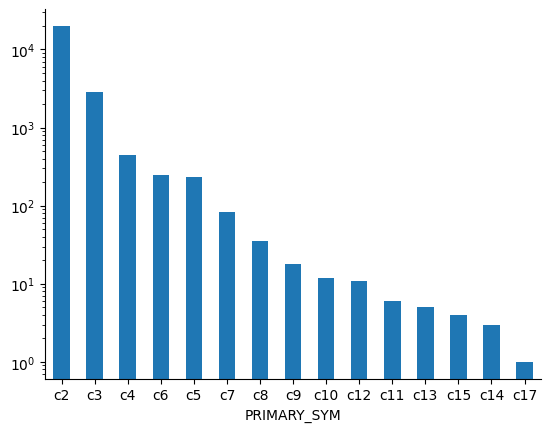

In [121]:
cx = cyclic_assemblies_variants.plot(kind="bar")
cx.spines['top'].set_visible(False)
cx.spines['right'].set_visible(False)
cx.set_yscale('log')
cx.set_xticklabels(cx.get_xticklabels(), rotation=0)

In [122]:
# Show all the dihedral assemblies variants
dihedral_assemblies_variants = dihedral_assemblies['PRIMARY_SYM'].value_counts()
dihedral_assemblies_variants

PRIMARY_SYM
d2     3364
d3     1120
d4      384
d5      126
d6       91
d7       57
d8       18
d9        2
d17       2
d16       1
d10       1
d24       1
Name: count, dtype: int64

[Text(0, 0, 'd2'),
 Text(1, 0, 'd3'),
 Text(2, 0, 'd4'),
 Text(3, 0, 'd5'),
 Text(4, 0, 'd6'),
 Text(5, 0, 'd7'),
 Text(6, 0, 'd8'),
 Text(7, 0, 'd9'),
 Text(8, 0, 'd17'),
 Text(9, 0, 'd16'),
 Text(10, 0, 'd10'),
 Text(11, 0, 'd24')]

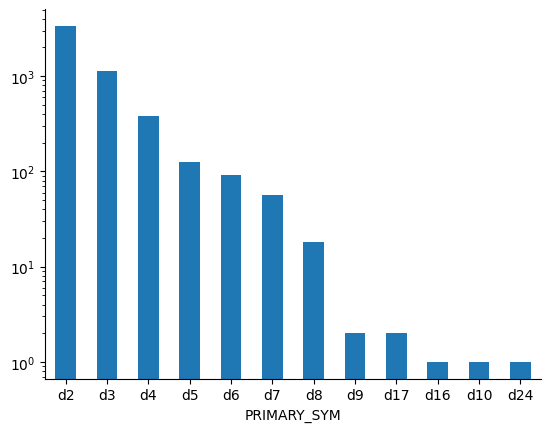

In [123]:
dx = dihedral_assemblies_variants.plot(kind="bar")
# dx.set_title("Dihedral (Dn) symmetry groups detected")
dx.spines['top'].set_visible(False)
dx.spines['right'].set_visible(False)
dx.set_yscale('log')
dx.set_xticklabels(dx.get_xticklabels(), rotation=0)

## 5.3) Listing assemblies with inconsistent symmetries

We can list assemblies where the symmetry data is inconsistent between different instances of the same assembly. This can highlight potential annotation errors, or genuinely interesting assemblies.

In [124]:
df_inconsistent_symmetry = df_protein[df_protein['CONSISTENT_SYMMETRY'] == False]
# Number of unique assemblies containing members with inconsistent symmetry
df_inconsistent_symmetry.shape[0]

1449

We can also investigate the data by explicitly excluding asymmetric C1 instance.

In [130]:
# Assemblies with inconsistent symmetry operators (excluding asymmetric C1)
df_protein[(df_protein["CONSISTENT_SYMMETRY"] == False) & (~df_protein["SYMMETRY_OPS"].str.contains("no-sym"))]

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,SYMMETRY_OPS,CONSISTENT_SYMMETRY,SYM_NUM,ALL_SYM,PRIMARY_SYM
81,A0A024B7W1_180,567d51b7c0deacf4eeb3690db47e5483,"A0A024B7W1_180|291_693,antibody_5h32_2_180|1_1...",PDB-CPX-100082,nan,RNA-directed RNA polymerase NS5,protein name from UniProt,"5h32_1,5uhy_1,5y0a_1,9js7_1","5h32_1,5uhy_1,5y0a_1,9js7_1",False,...,False,False,protein,True,True,"i,i,i,d5",False,2,"d5, i",i
1334,A0A0F5HPP7_240,2c69254f3ed5d67c03398ca236901c1d,"A0A0F5HPP7_240|1_282,peptide_6nj8_2_180|1_7,A0...",PDB-CPX-101335,nan,Type 1 encapsulin shell protein,protein name from UniProt,"6nj8_1,7mh2_1,8rvj_1","6nj8_1,7mh2_1,8rvj_1",False,...,False,False,protein,True,True,"d5,i,i",False,2,"d5, i",i
1850,A0A0H2ZIZ8_2,25307304da5e31a99b705845bb427197,"A0A0H2ZIZ8_2|1_71,A0A0H2ZIZ8_2|1_71,shRNA_4kji...",PDB-CPX-101851,nan,Carbon storage regulator,protein name from UniProt,"4k59_1,4kji_1,4krw_1","4k59_1,4kji_1,4krw_1",False,...,False,False,protein,True,True,"c3,c3,c2",False,2,"c3, c2",c3
1994,A0A0H3CDS2_6,55e9d366ca285e5f1f4065503dc984b2,A0A0H3CDS2_6|80_501,PDB-CPX-101995,nan,Bacterial type II secretion system protein E d...,protein name from UniProt,"8rjf_1,8rkd_1,8rkl_1","8rjf_1,8rkd_1,8rkl_1",False,...,False,False,protein,True,True,"c6,c6,c2",False,2,"c6, c2",c6
2894,"A0A0S2PZC9_180,A0A482JI47_180",645a87f669241c45f068eb1664479eb9,"A0A0S2PZC9_180|281_775,A0A482JI47_180|206_280,...",PDB-CPX-102895,nan,Membrane polyprotein and Envelope protein,heterodimer,"8y3g_1,8y3h_1,8y3i_1,8y3k_1,8y3l_1","8y3g_1,8y3h_1,8y3i_1,8y3k_1,8y3l_1",False,...,False,False,protein,True,True,"i,i,i,i,d5",False,2,"d5, i",i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92266,Q9WZ49_6,dbc80636220d882b0ceb5f6472c3828b,"Q9WZ49_6|147_610,Q9WZ49_6|34_101,Q9WZ49_6|1_610",PDB-CPX-192267,nan,ATP-dependent zinc metalloprotease FtsH,protein name from UniProt,"2ce7_1,2ce7_2,2cea_1,2cea_2,3kds_1,3kds_2,4m8a...","2ce7_1,2cea_1,3kds_1,4m8a_1,4q0f_1,7tdo_1",False,...,False,False,protein,True,True,"c2,c2,c6,c2,c2,c6",False,2,"c6, c2",c2
92918,Q9Y3Z3_4,a050b4e1b42263f2b3a94a370ded1bec,"Q9Y3Z3_4|113_626,Q9Y3Z3_4|109_626,Q9Y3Z3_4|41_...",PDB-CPX-192919,nan,Deoxynucleoside triphosphate triphosphohydrola...,protein name from UniProt,"4bzb_1,4bzc_1,4mz7_1,4qfx_1,4qfy_1,4qfz_1,4qg0...","4bzb_1,4bzc_1,4mz7_1,4qfx_1,4qfy_1,4qfz_1,4qg0...",False,...,False,False,protein,True,True,"d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d...",False,2,"c2, d2",d2
93071,Q9Y6M5_2,158185ca9d42b777e14b639286c7634b,"Q9Y6M5_2|1_507,Q9Y6M5_2|348_421",PDB-CPX-193072,CPX-8381,ZNT1 proton-coupled zinc antiporter homodimer,complex portal,"8j2g_1,8xm6_1,8xma_1,8xmf_1,8xmj_1,8zb0_1,8zsb...","8j2g_1,8xm6_1,8xma_1,8xmf_1,8xmj_1,8zb0_1,8zsb...",False,...,False,False,protein,True,True,"c2,c2,c2,c2,c2,c2,c2,c2,c3,c2,c2",False,2,"c3, c2",c2
94616,V6F235_2,876fff3d76400d8acc494a28ad16516d,"V6F235_2|215_318,V6F235_2|215_293",PDB-CPX-194617,nan,Magnetosome protein MamM,protein name from UniProt,"3w5x_1,3w5y_1,3w5z_1,3w60_1,3w61_1,3w62_1,3w63...","3w5x_1,3w5y_1,3w5z_1,3w60_1,3w61_1,3w62_1,3w63...",False,...,False,False,protein,True,True,"c2,c2,c2,c2,c2,c2,c2,c3,c2,c2,c2,c2,c2,c2,c2,c...",False,2,"c3, c2",c2


# 6) Complexes with bound macromolecules

In our process, we treat antibodies, peptides (less than 20 amino acids) and short nucleic acid fragments (less than 25 nucleotides) as bound macromolecules and not as core components of complexes

In [125]:
df_bound = pd.read_csv("data/bound_molecules_data.csv")

In [126]:
df_bound.shape[0]

32229

In [127]:
unique_complex_counts = df_bound.groupby('BOUND_MOLECULE_TYPE')['PDB_COMPLEX_ID'].nunique().sort_values(ascending=False)
unique_complex_counts

BOUND_MOLECULE_TYPE
antibody         3266
short DNA        2526
peptide          2256
short RNA        1653
tRNA              909
mRNA              460
short DNA/RNA      63
Name: PDB_COMPLEX_ID, dtype: int64

In [128]:
share = (unique_complex_counts / unique_complex_counts.sum() * 100).round(1)
type_share = pd.DataFrame({'n_complexes': unique_complex_counts, 'percent': share})
type_share

,n_complexes,percent
BOUND_MOLECULE_TYPE,,
antibody,3266,29.3
short DNA,2526,22.7
peptide,2256,20.3
short RNA,1653,14.8
tRNA,909,8.2
mRNA,460,4.1
short DNA/RNA,63,0.6


In [ ]:
It appears

## Conclusion

This work provides an archive-wide analysis of assemblies in the PDB archive and demonstrates the power of mapping individual components of assemblies to external databases. Our new approach allows the otherwise complex aggregation of assemblies. With the help of mappings to external databases, it also became possible to name over 80% of assemblies in the PDB, representing over 90% of PDB entries. These names allow users of PDBe to find complexes that previously could only be found by relying on the title of the PDB entry or listing all the complex components. Searching by title or listing components is likely to lead to incomplete and inconsistent search results due to the heterogeneity of assemblies in the PDB archive. We are making the complexes name list and mapping data files available to the community to aid in analysing and identifying macromolecular complexes.

## Authors

* Sri Appasamy
* Mihaly Varadi

### Last updated October 2025